In [95]:
# Install required packages (if not already installed)
!pip install scanpy anndata seaborn scikit-learn --quiet


In [96]:
!pip install torch-geometric -q


In [97]:
# Step 2: Import Libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set visualization style
sns.set_style("whitegrid")


In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
# Load the dataset
file_path = '/content/drive/MyDrive/GSE155121_human_data_raw.h5ad'
# Load the dataset
adata = sc.read_h5ad(file_path)

# Show basic info
print(adata)
print("Dataset Loaded Successfully!")


AnnData object with n_obs × n_vars = 463304 × 32738
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0'
Dataset Loaded Successfully!


Dataset Summary:
Number of cells: 463304, Number of genes: 32738
First few cell observations:


,week_stage
index,
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0,W3-1


First few gene features:


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object', name='index')

Shape of raw dataset: (463304, 32738)
Total Missing Values in Dataset: 0


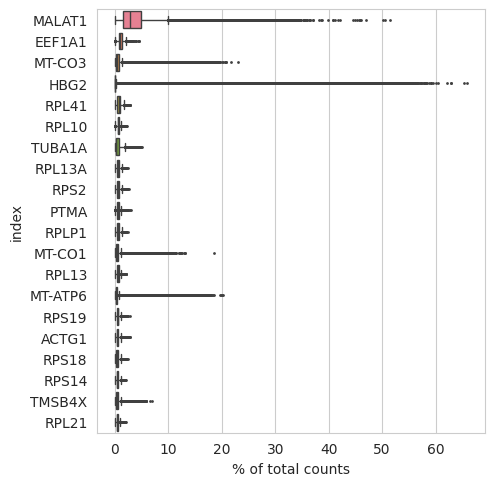

In [100]:
# Summarizing dataset structure
print("Dataset Summary:")
print(f"Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")
print("First few cell observations:")
display(adata.obs.head())
print("First few gene features:")
display(adata.var_names[:10])
print("Shape of raw dataset:", adata.X.shape)

# Check for missing values
# Convert adata.X to a dense NumPy array before checking for NaN
print("Total Missing Values in Dataset:", np.isnan(adata.X.toarray()).sum()) # The toarray() method converts a sparse matrix to a dense NumPy array.

# Visualizing most expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [101]:
!pip install scikit-misc

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


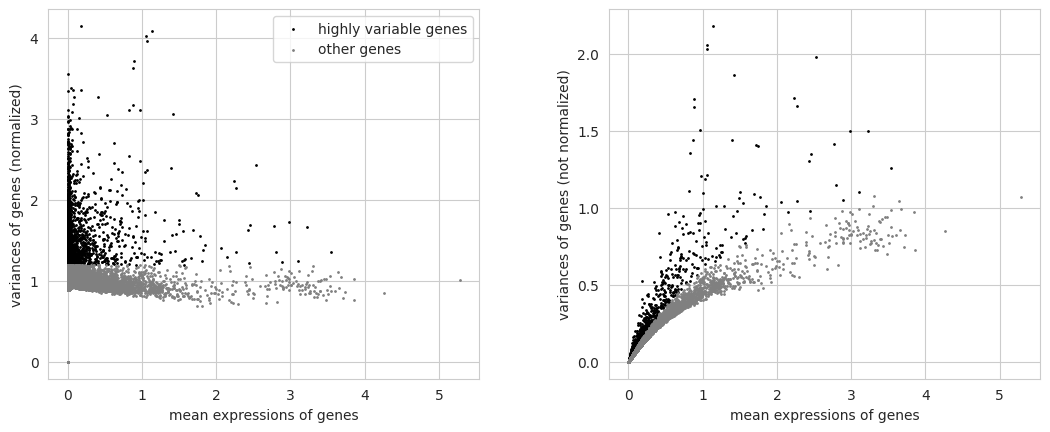

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [102]:
# Convert the sparse matrix to a dense array for the check
if np.any(adata.X.toarray() < 0):  # Log transformation should not have negative values
    print("Data is already log-transformed, skipping log1p step.")
else:
    sc.pp.log1p(adata)  # Apply log transformation only if needed

# Identifying Highly Variable Genes (Fixing Previous Error)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)  # Corrected function call

# Visualizing highly variable genes
sc.pl.highly_variable_genes(adata)

# Filter only the highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scaling Data
sc.pp.scale(adata, max_value=10)


In [103]:
# Display dataset info
print(adata)
print("Data Preprocessing Completed!")

AnnData object with n_obs × n_vars = 463304 × 2000
    obs: 'week_stage'
    var: 'gene_ids', 'feature_types-1-0-0-0-0-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0-0-0', 'feature_types-1-0-0-0-0-0', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
Data Preprocessing Completed!


In [104]:
# Step 4: Exploratory Data Analysis (EDA)
# 1️⃣ Summary of Metadata
print("Available Metadata Columns:", adata.obs.columns)
print("Dataset Overview:")
print(adata.obs.head())


Available Metadata Columns: Index(['week_stage'], dtype='object')
Dataset Overview:
                                           week_stage
index                                                
AAACCTGAGAATGTTG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1
AAACCTGAGCCAGAAC-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1
AAACCTGAGGCAGTCA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1
AAACCTGAGGGATGGG-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1
AAACCTGAGTGACATA-1-0-0-0-0-0-0-0-0-0-0-0-0       W3-1


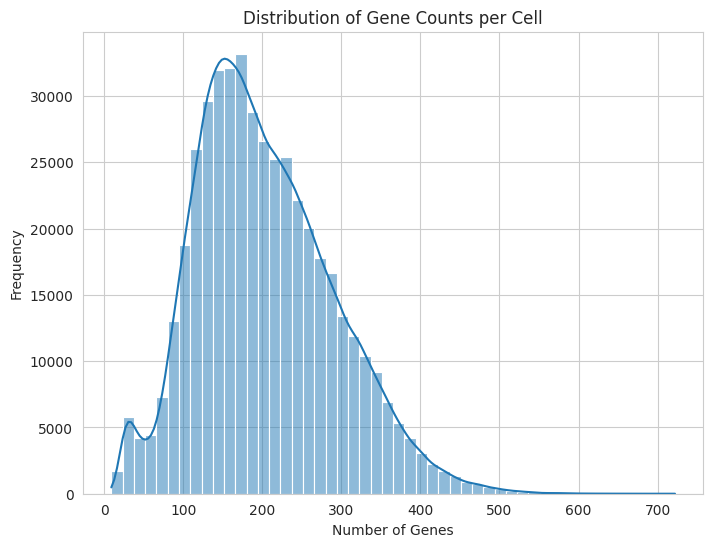

In [105]:
# 2️⃣ Distribution of Genes per Cell
adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)
plt.figure(figsize=(8,6))
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True)
plt.title("Distribution of Gene Counts per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Frequency")
plt.show()

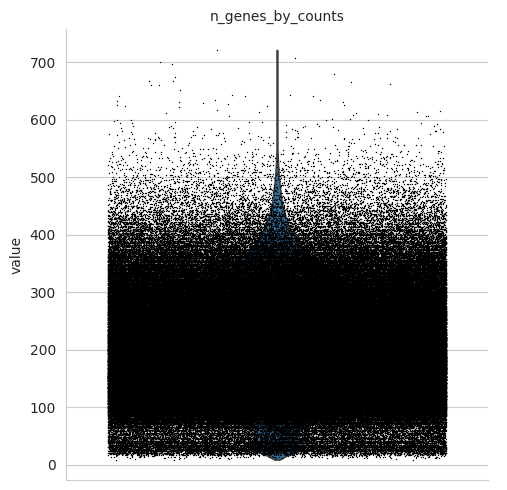

In [106]:
# 3️⃣ Violin Plot of Gene Expression
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, multi_panel=True)

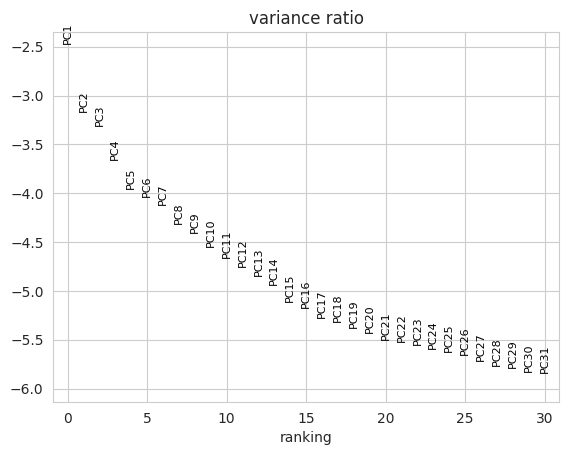

In [107]:
# 4️⃣ PCA for Dimensionality Reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [108]:
# Step 5: Construct Graph Representation
# Convert gene expression data into a graph structure

def build_gene_interaction_graph(adata):
    G = nx.Graph()
    genes = list(adata.var_names)

    # Add nodes (genes)
    for gene in genes:
        G.add_node(gene)

    # Define edges based on correlation (temporary method, can be replaced with known interactions)
    expression_matrix = adata.X.T  # Transpose to have genes as rows
    correlation_matrix = np.corrcoef(expression_matrix)

    threshold = 0.7  # Adjust for significant correlations
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if correlation_matrix[i, j] > threshold:
                G.add_edge(genes[i], genes[j], weight=correlation_matrix[i, j])

    return G

In [109]:
# Build graph
gene_graph = build_gene_interaction_graph(adata)
print(f"Graph constructed with {gene_graph.number_of_nodes()} nodes and {gene_graph.number_of_edges()} edges.")

Graph constructed with 2000 nodes and 519 edges.


In [110]:
# Step 6: Convert Graph to PyTorch Geometric Format

def convert_to_pyg_data(graph):
    node_index = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = []
    edge_attr = []

    for u, v, data in graph.edges(data=True):
        edge_index.append([node_index[u], node_index[v]])
        edge_attr.append(data['weight'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Convert gene expression data into PyTorch tensor
    x = torch.tensor(adata.X, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [111]:
# Convert to PyTorch Geometric format
gene_graph_data = convert_to_pyg_data(gene_graph)
print("Graph successfully converted to PyTorch Geometric format!")

Graph successfully converted to PyTorch Geometric format!


In [112]:
# Step 7: Implement Graph Attention Network (GAT)
class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=3):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [113]:
# Define Model Parameters
input_dim = gene_graph_data.x.shape[1]
hidden_dim = 64
output_dim = len(set(adata.obs['week_stage']))  # Assuming week_stage as target labels

In [114]:
import torch.optim as optim

In [115]:
# Initialize Model
gat_model = GATModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [116]:
import torch.nn.functional as F

In [117]:
from sklearn.preprocessing import LabelEncoder

In [118]:
# Step 8: Train GAT Model with Training & Validation Splitting
def train_model(model, data, epochs=100, patience=10):
    model.train()
    encoder = LabelEncoder()

    if 'week_stage_encoded' not in adata.obs.columns:
        adata.obs['week_stage_encoded'] = encoder.fit_transform(adata.obs['week_stage'])

    # Split indices into training (80%) and validation (20%)
    indices = np.arange(len(adata))
    np.random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_indices, val_indices = indices[:split_idx], indices[split_idx:]

    # Split the dataset into training and validation sets
    train_x = data.x[train_indices]
    val_x = data.x[val_indices]

    train_labels = torch.tensor(adata.obs['week_stage_encoded'].values[train_indices], dtype=torch.long)
    val_labels = torch.tensor(adata.obs['week_stage_encoded'].values[val_indices], dtype=torch.long)

    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(Data(x=train_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
        loss = criterion(out, train_labels)
        loss.backward()
        optimizer.step()

        # Store training loss & accuracy
        loss_history.append(loss.item())
        train_preds = out.argmax(dim=1).detach().cpu().numpy()
        train_acc = accuracy_score(train_labels.cpu().numpy(), train_preds)
        accuracy_history.append(train_acc)

        # Validation step
        model.eval()
        with torch.no_grad():
            val_out = model(Data(x=val_x, edge_index=data.edge_index, edge_attr=data.edge_attr))
            val_loss = criterion(val_out, val_labels)
            val_loss_history.append(val_loss.item())
            val_preds = val_out.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(val_labels.cpu().numpy(), val_preds)
            val_accuracy_history.append(val_acc)
        model.train()

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

    return loss_history, accuracy_history, val_loss_history, val_accuracy_history

# Train the model
loss_history, accuracy_history, val_loss_history, val_accuracy_history = train_model(gat_model, gene_graph_data)


Epoch 0, Loss: 3.0982, Accuracy: 0.0855, Val Loss: 3.2955, Val Accuracy: 0.4772
Epoch 10, Loss: 0.3791, Accuracy: 0.9043, Val Loss: 0.3496, Val Accuracy: 0.9145
Epoch 20, Loss: 0.1266, Accuracy: 0.9617, Val Loss: 0.1525, Val Accuracy: 0.9571
Epoch 30, Loss: 0.0738, Accuracy: 0.9762, Val Loss: 0.0914, Val Accuracy: 0.9746
Epoch 40, Loss: 0.0469, Accuracy: 0.9858, Val Loss: 0.0663, Val Accuracy: 0.9822
Epoch 50, Loss: 0.0368, Accuracy: 0.9896, Val Loss: 0.0557, Val Accuracy: 0.9857
Epoch 60, Loss: 0.0305, Accuracy: 0.9920, Val Loss: 0.0501, Val Accuracy: 0.9880
Epoch 70, Loss: 0.0267, Accuracy: 0.9933, Val Loss: 0.0455, Val Accuracy: 0.9890
Epoch 80, Loss: 0.0241, Accuracy: 0.9944, Val Loss: 0.0422, Val Accuracy: 0.9900
Epoch 90, Loss: 0.0223, Accuracy: 0.9951, Val Loss: 0.0397, Val Accuracy: 0.9908


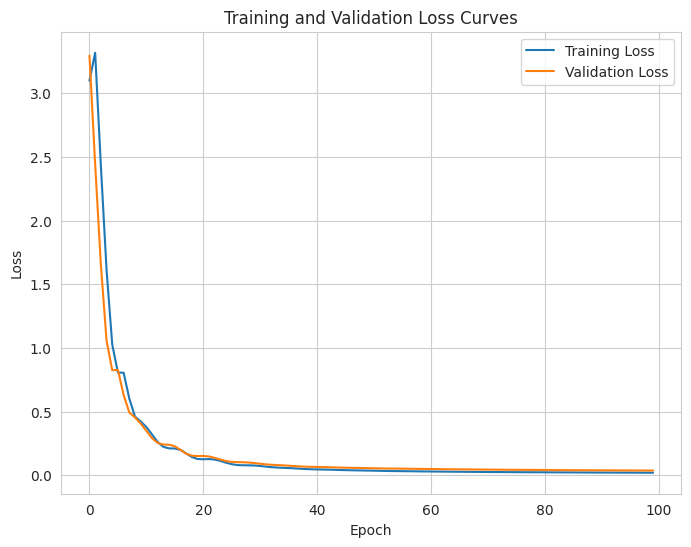

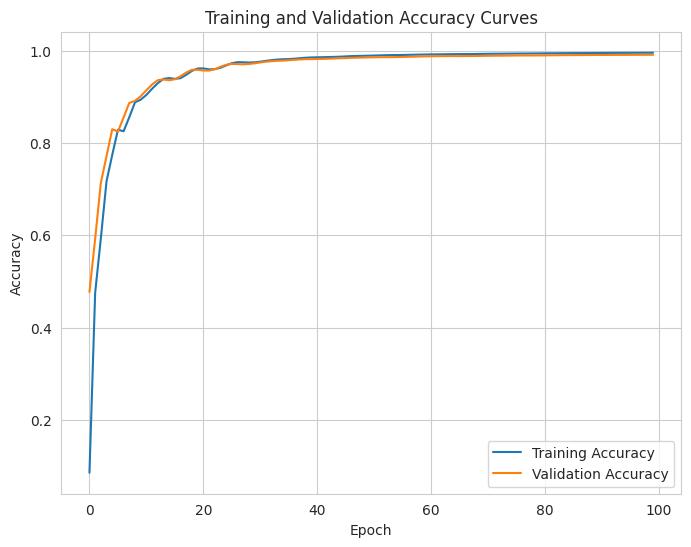

In [119]:
# Define plot_loss_curve function
def plot_loss_curve(loss_history, val_loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()

# Define plot_accuracy_curve function
def plot_accuracy_curve(accuracy_history, val_accuracy_history):
    plt.figure(figsize=(8, 6))
    plt.plot(accuracy_history, label="Training Accuracy")
    plt.plot(val_accuracy_history, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.show()

# Plot Training vs Validation Curves
plot_loss_curve(loss_history, val_loss_history)
plot_accuracy_curve(accuracy_history, val_accuracy_history)

In [120]:
# Get predictions for the entire dataset
gat_model.eval()  # Set the model to evaluation mode # Changed 'model' to 'gat_model'
with torch.no_grad():
    out = gat_model(gene_graph_data)  # Changed 'model' to 'gat_model' and 'data' to 'gene_graph_data'
    _, predictions = torch.max(out, 1)

In [121]:
# Get true labels for the entire dataset
true_labels = adata.obs['week_stage_encoded'].values

In [122]:
# Compute Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {acc:.4f}")

Model Accuracy: 0.9953


In [123]:
# Classification Report
print("Classification Report:\n", classification_report(true_labels, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     36368
           1       1.00      1.00      1.00     12530
           2       1.00      1.00      1.00     43086
           3       1.00      0.99      1.00     40878
           4       1.00      1.00      1.00     30038
           5       1.00      1.00      1.00     38833
           6       1.00      1.00      1.00     54352
           7       1.00      1.00      1.00     41811
           8       1.00      1.00      1.00     26610
           9       0.99      0.99      0.99     42080
          10       0.99      0.99      0.99     30495
          11       0.99      0.99      0.99     38004
          12       0.99      0.99      0.99     28219

    accuracy                           1.00    463304
   macro avg       1.00      1.00      1.00    463304
weighted avg       1.00      1.00      1.00    463304



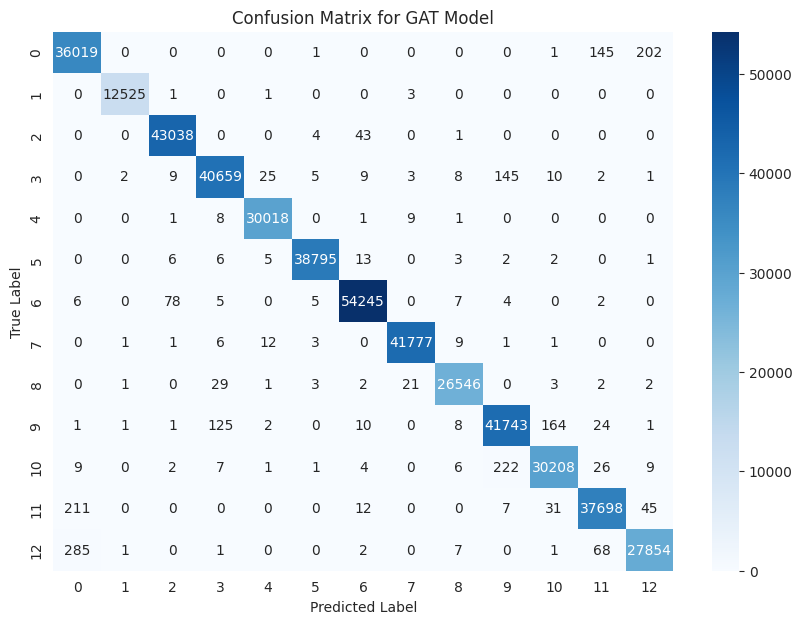

In [124]:
    # Confusion Matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GAT Model")
    plt.show()

Top 50 Most Important Genes:
               Gene  Importance
535            GYPB    1.000000
26             C1QC    0.855735
6              ENO1    0.824236
25             C1QA    0.705809
130           CKS1B    0.687510
92             CD53    0.669688
27             C1QB    0.644287
216           CENPF    0.639757
803        HOXA-AS3    0.549748
402           GAP43    0.535696
1988         MT-ND1    0.534565
899           GPR34    0.517818
825    RP11-797H7.5    0.470791
110          MLLT11    0.456589
985           STMN2    0.446688
536            GYPA    0.443812
157             MPZ    0.428669
457           CRMP1    0.422595
550           HMGB2    0.416581
1324           KRT8    0.408657
59           ELAVL4    0.394698
190            ASPM    0.392688
329          EEF1B2    0.388153
33            HMGN2    0.382405
53            CDC20    0.365583
1163            HBB    0.360916
1165           HBG1    0.350893
295            TBR1    0.349031
180           PRDX6    0.341661
1990       

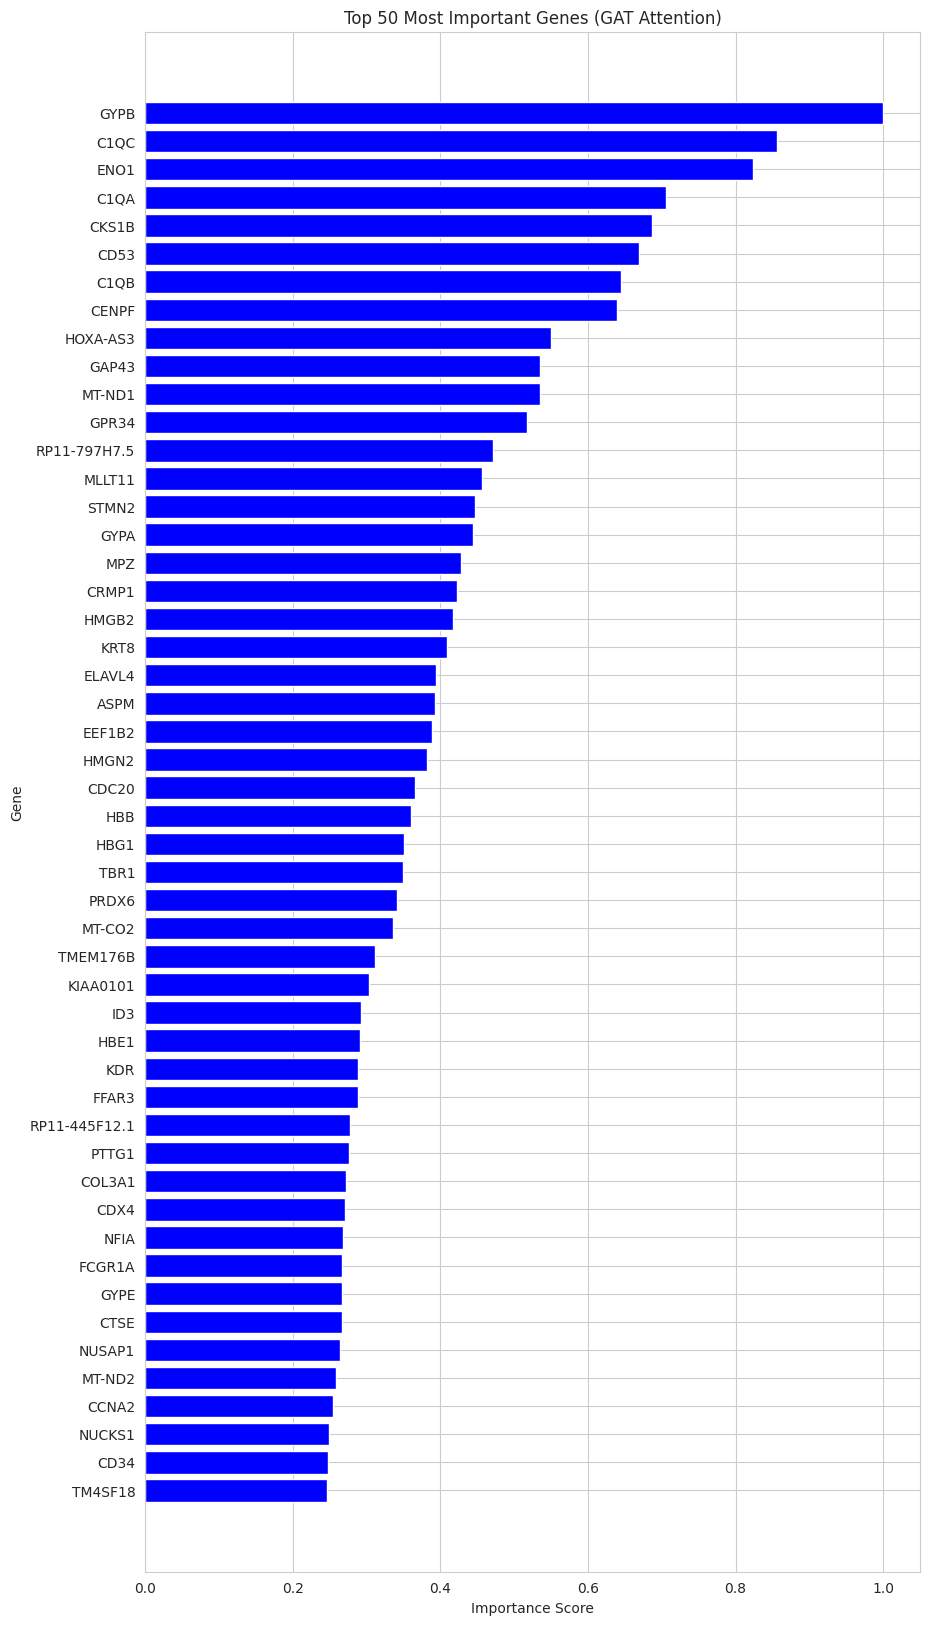

In [125]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract attention weights from GAT
def extract_attention_weights(model, data):
    model.eval()
    with torch.no_grad():
        _, (edge_index, attention_weights) = model.conv1(data.x, data.edge_index, return_attention_weights=True)

    return edge_index.cpu().numpy(), attention_weights.cpu().numpy()

# Extract attention weights
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data)

# If multi-head attention, average over heads
if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
    attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

# Aggregate attention scores per **gene** (not per node)
gene_names = list(adata.var_names)  # 2000 genes
gene_importance = np.zeros(len(gene_names))

# Map node indices to genes
node_to_gene_map = adata.var_names.to_list()  # Ensure genes are correctly mapped

for i in range(edge_index.shape[1]):
    source = edge_index[0, i]  # Source node index
    if source < len(gene_names):  # Ensure mapping only within gene list
        weight = attention_weights[i]
        gene_importance[source] += weight  # Sum attention scores per gene

# Normalize importance scores
gene_importance /= np.max(gene_importance)  # Normalize to range [0, 1]

# Create DataFrame with gene names and importance
gene_importance_df = pd.DataFrame({"Gene": gene_names, "Importance": gene_importance})
gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False)

# Display top 50 most important genes
print("Top 50 Most Important Genes:")
print(gene_importance_df.head(50))

# Plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(gene_importance_df["Gene"][:50], gene_importance_df["Importance"][:50], color="blue")
plt.xlabel("Importance Score")
plt.ylabel("Gene")
plt.title("Top 50 Most Important Genes (GAT Attention)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


In [126]:
import pandas as pd
import torch

# Get unique weeks
unique_weeks = adata.obs['week_stage'].unique()

# Dictionary to store results
top_genes_per_week = {}

# Iterate through each week
for week in unique_weeks:
    print(f"Processing Week: {week}")

    # Subset data for the current week
    week_mask = adata.obs['week_stage'] == week

    # Create a new Data object with the subsetted data and original graph structure
    week_data = Data(x=gene_graph_data.x[week_mask],
                     edge_index=gene_graph_data.edge_index,
                     edge_attr=gene_graph_data.edge_attr)

    # Get attention scores for this week
    with torch.no_grad():
        gat_output = gat_model(week_data)  # Run GAT on the week's data

        # Get attention weights from the first GATConv layer
        _, (edge_index, attention_weights) = gat_model.conv1(week_data.x, week_data.edge_index, return_attention_weights=True)
        attention_weights = attention_weights.cpu().numpy()

        # If multi-head attention, average over heads
        if attention_weights.ndim == 2:  # Shape (num_edges, num_heads)
            attention_weights = np.mean(attention_weights, axis=1)  # Take mean across heads

        # Aggregate attention scores per gene
        gene_importance = np.zeros(len(adata.var_names))
        for i in range(edge_index.shape[1]):
            source = edge_index[0, i].item()  # Get source node index as an integer
            if source < len(adata.var_names):
                gene_importance[source] += attention_weights[i]

        # Normalize importance scores
        gene_importance /= np.max(gene_importance) if np.max(gene_importance) != 0 else 1  # Avoid division by zero


    # Create DataFrame of genes and importance
    gene_importance_df = pd.DataFrame({
        "Gene": adata.var_names,
        "Importance": gene_importance
    })

    # Sort and select top 20
    gene_importance_df = gene_importance_df.sort_values(by="Importance", ascending=False).head(20)

    # Store results
    top_genes_per_week[week] = gene_importance_df

# Display results
for week, df in top_genes_per_week.items():
    print(f"\nTop 20 Genes for Week {week}")
    print(df)

Processing Week: W3-1


<ipython-input-126-ac1088f67c33>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  week_data = Data(x=gene_graph_data.x[week_mask],


Processing Week: W4-1
Processing Week: W4-2
Processing Week: W4-3
Processing Week: W5-1
Processing Week: W5-2
Processing Week: W5-3
Processing Week: W6-1
Processing Week: W7-1
Processing Week: W8-1
Processing Week: W9-1
Processing Week: W9-2
Processing Week: W12-1

Top 20 Genes for Week W3-1
              Gene  Importance
535           GYPB    1.000000
26            C1QC    0.855735
6             ENO1    0.824236
25            C1QA    0.705809
130          CKS1B    0.687510
92            CD53    0.669688
27            C1QB    0.644287
216          CENPF    0.639757
803       HOXA-AS3    0.549748
402          GAP43    0.535696
1988        MT-ND1    0.534565
899          GPR34    0.517818
825   RP11-797H7.5    0.470791
110         MLLT11    0.456589
985          STMN2    0.446688
536           GYPA    0.443812
157            MPZ    0.428669
457          CRMP1    0.422595
550          HMGB2    0.416581
1324          KRT8    0.408657

Top 20 Genes for Week W4-1
          Gene  Importance
2

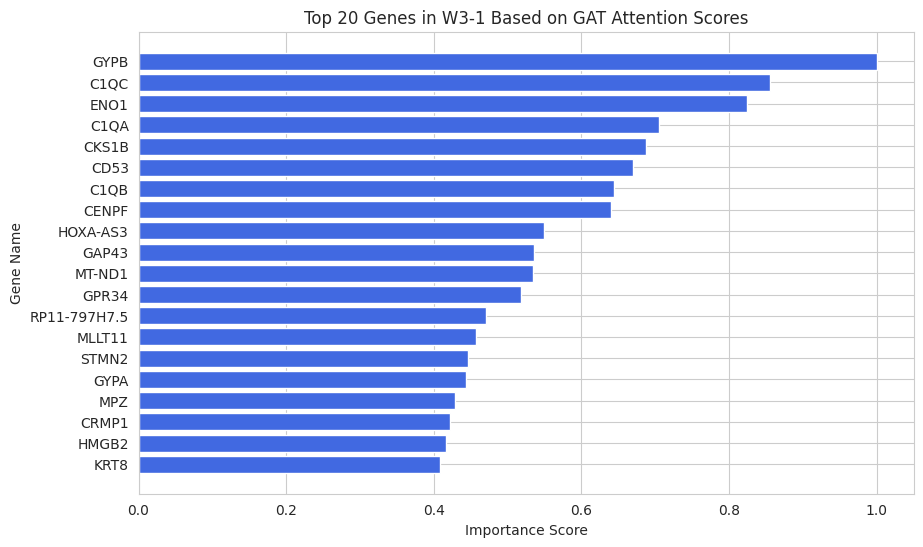

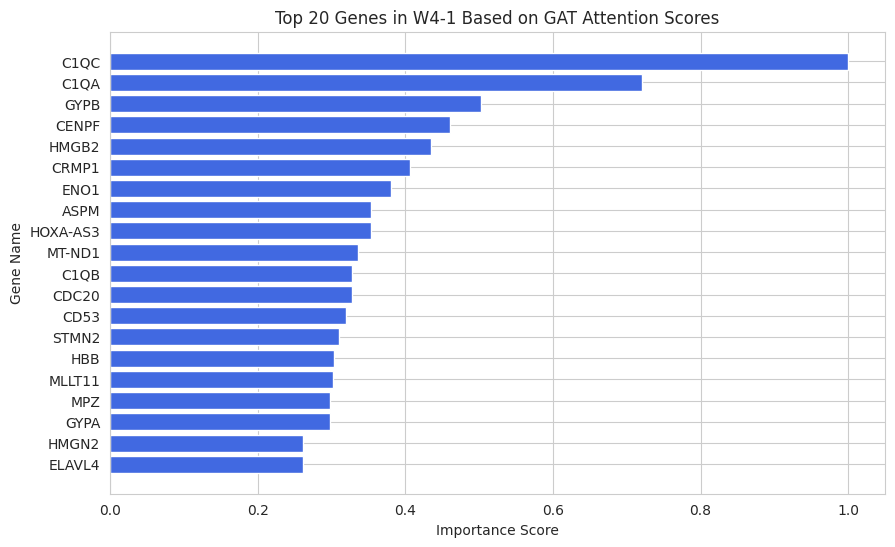

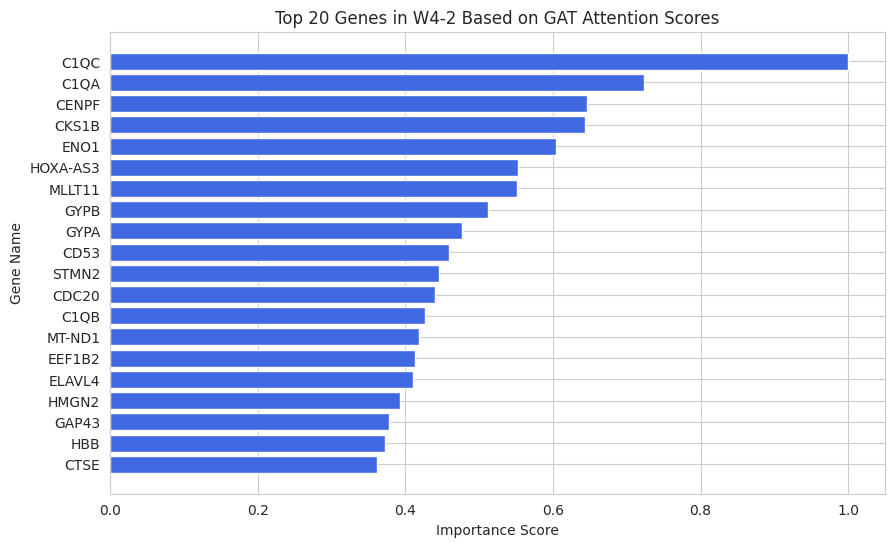

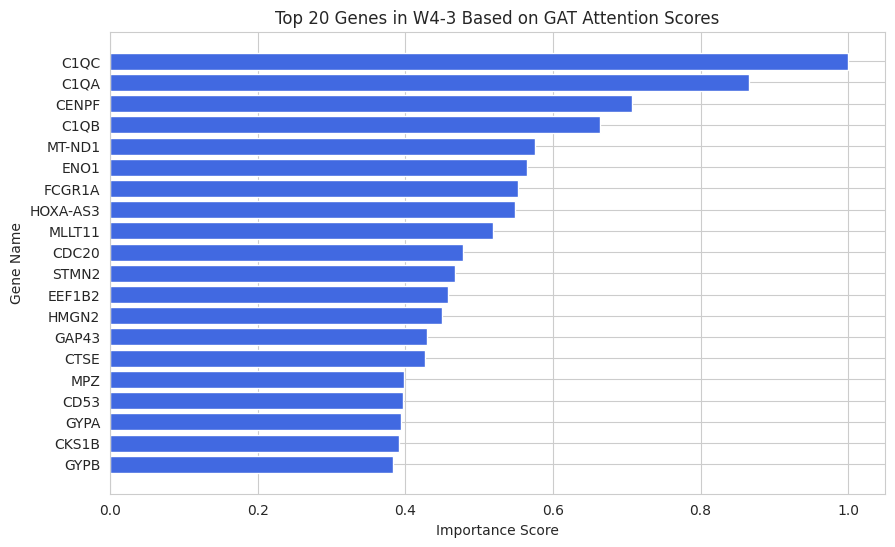

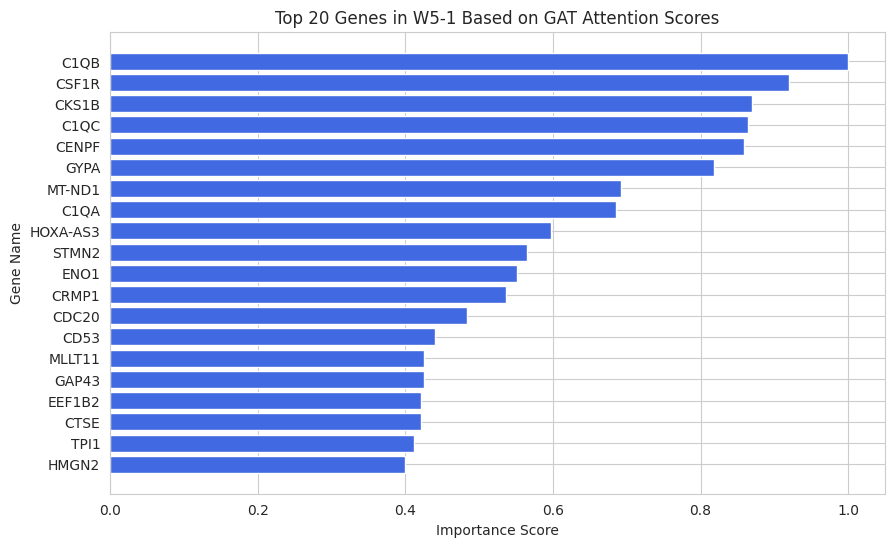

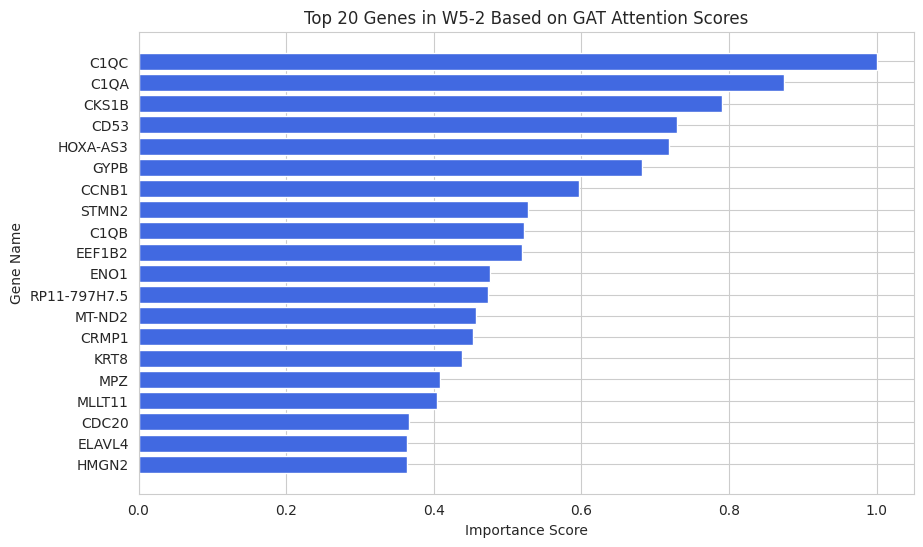

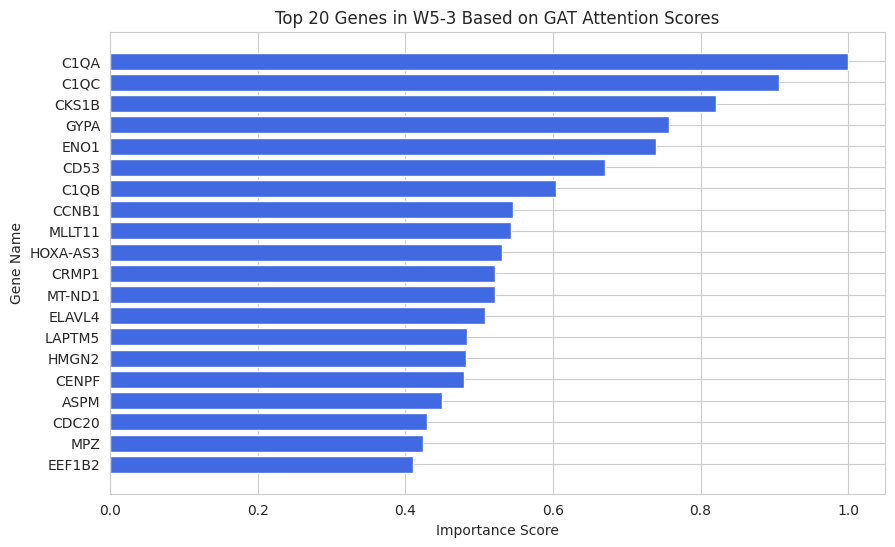

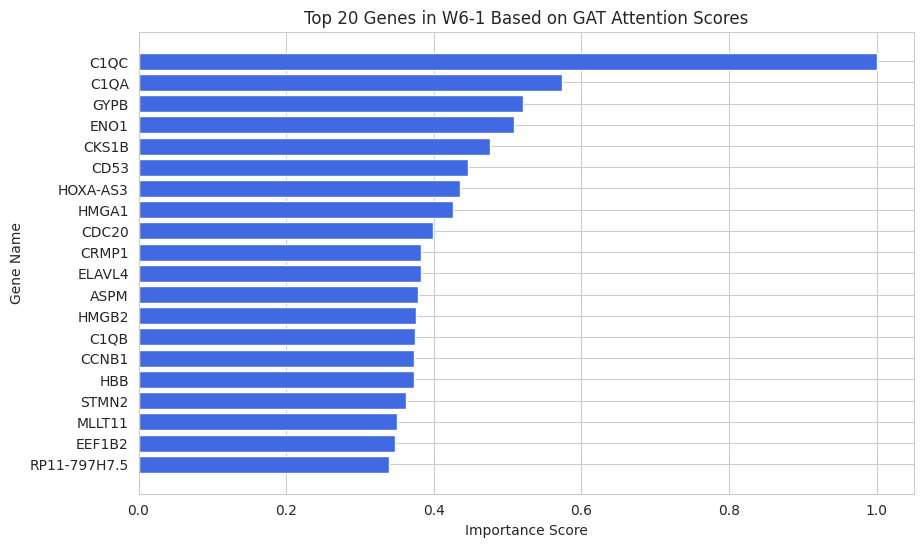

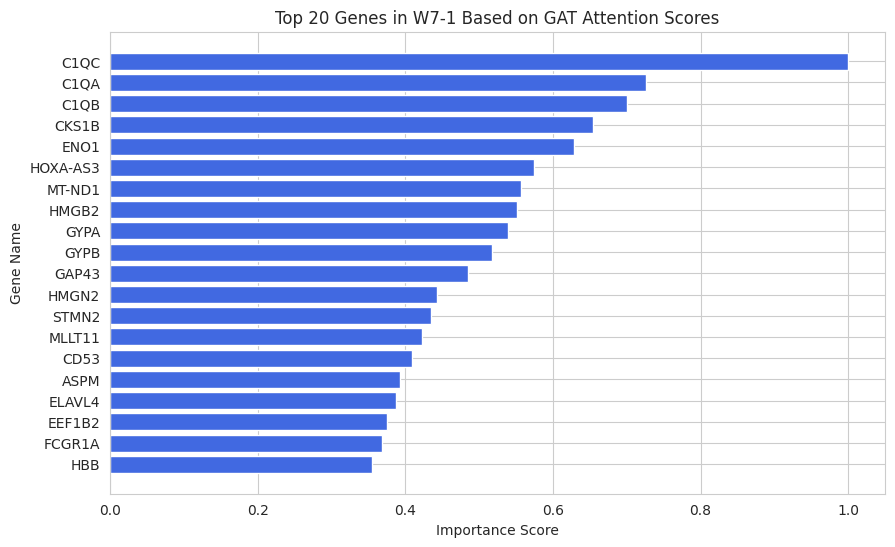

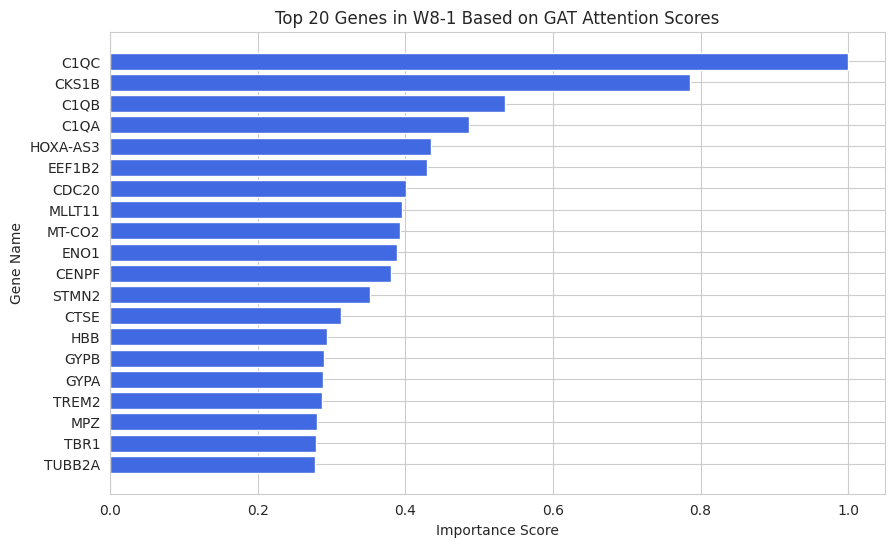

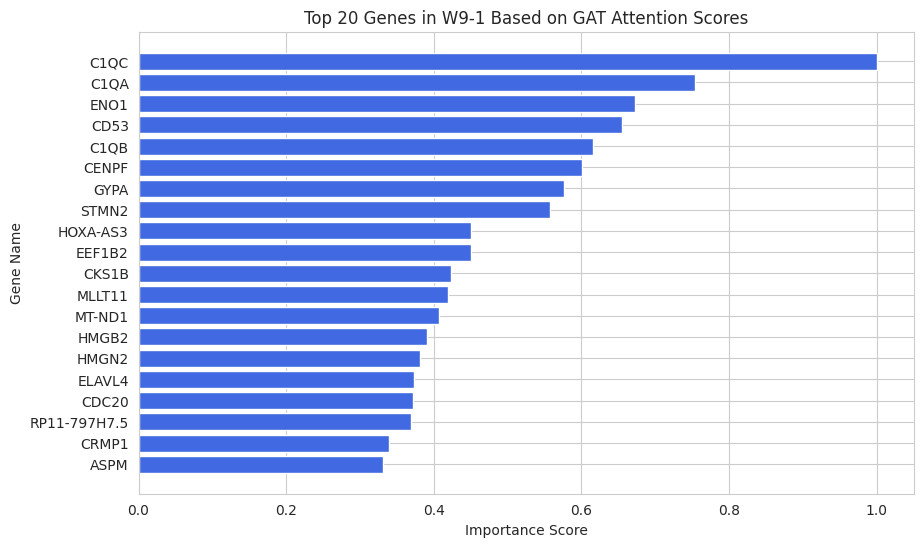

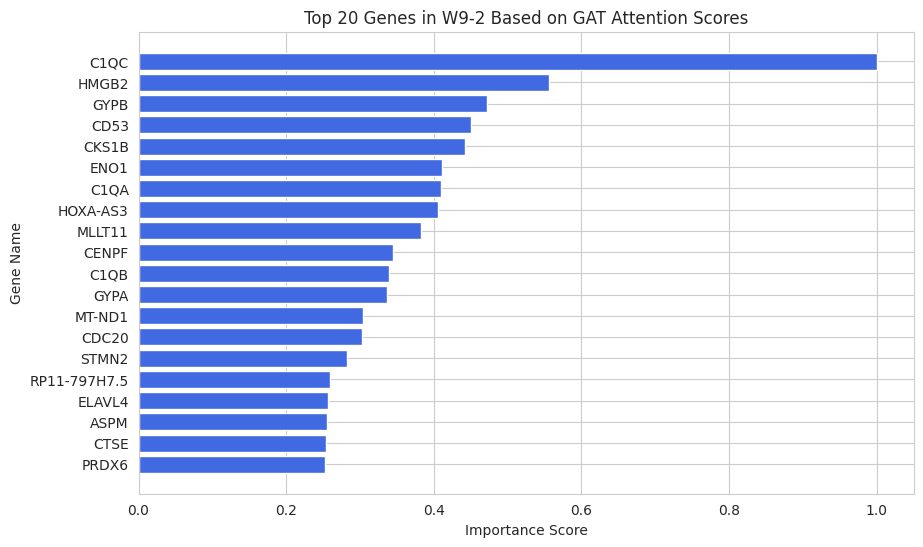

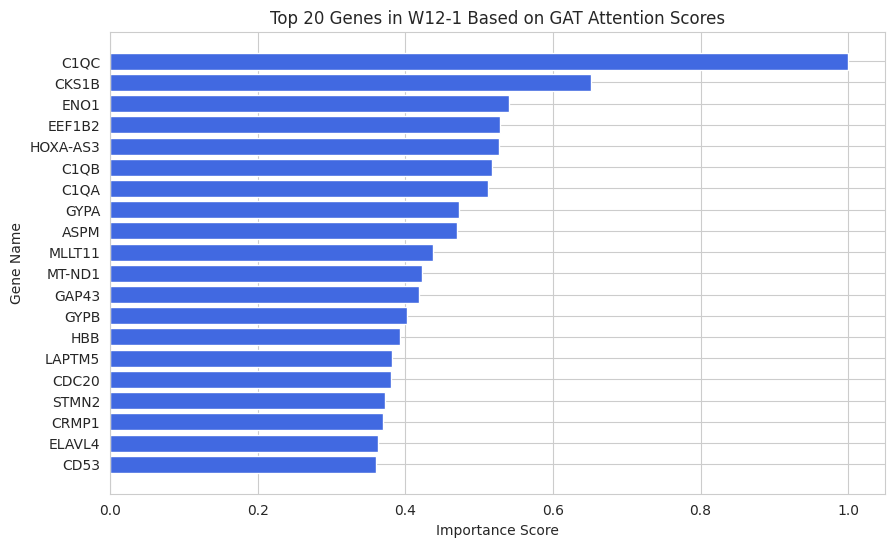

In [127]:
def plot_top_genes_bar(top_genes_per_week):
    for week, df in top_genes_per_week.items():
        plt.figure(figsize=(10, 6))
        plt.barh(df["Gene"], df["Importance"], color="royalblue")
        plt.xlabel("Importance Score")
        plt.ylabel("Gene Name")
        plt.title(f"Top 20 Genes in {week} Based on GAT Attention Scores")
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.show()

# Call the function with your data
plot_top_genes_bar(top_genes_per_week)

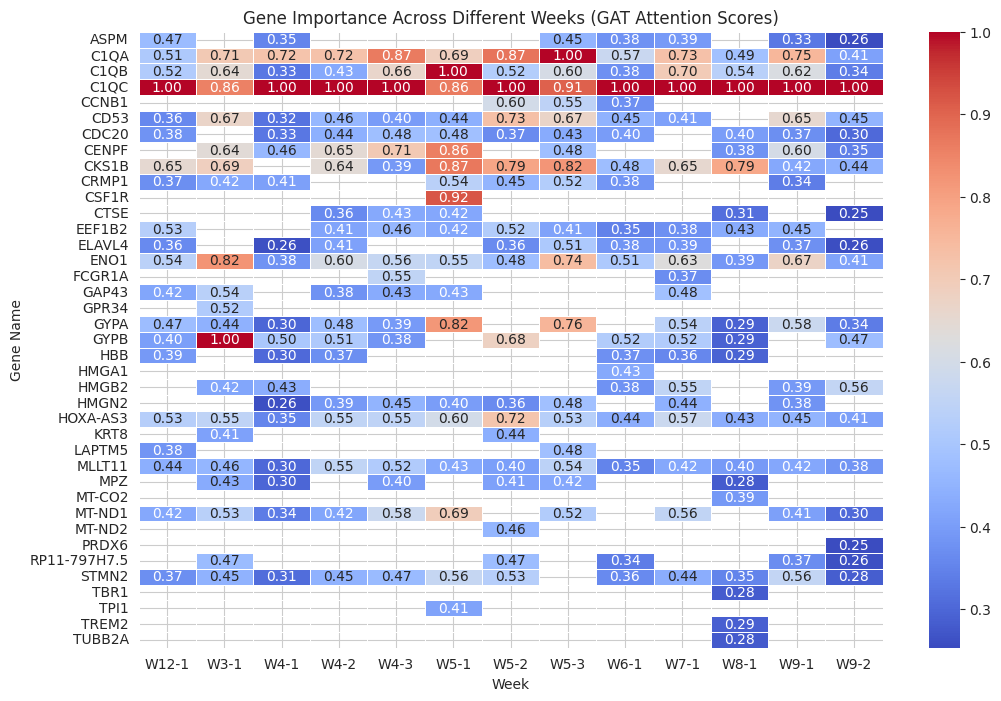

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionary of DataFrames to one combined DataFrame
heatmap_data = pd.concat(top_genes_per_week, names=["Week"]).reset_index()

# Pivot the DataFrame for heatmap format
heatmap_pivot = heatmap_data.pivot(index="Gene", columns="Week", values="Importance")

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Gene Importance Across Different Weeks (GAT Attention Scores)")
plt.xlabel("Week")
plt.ylabel("Gene Name")
plt.show()


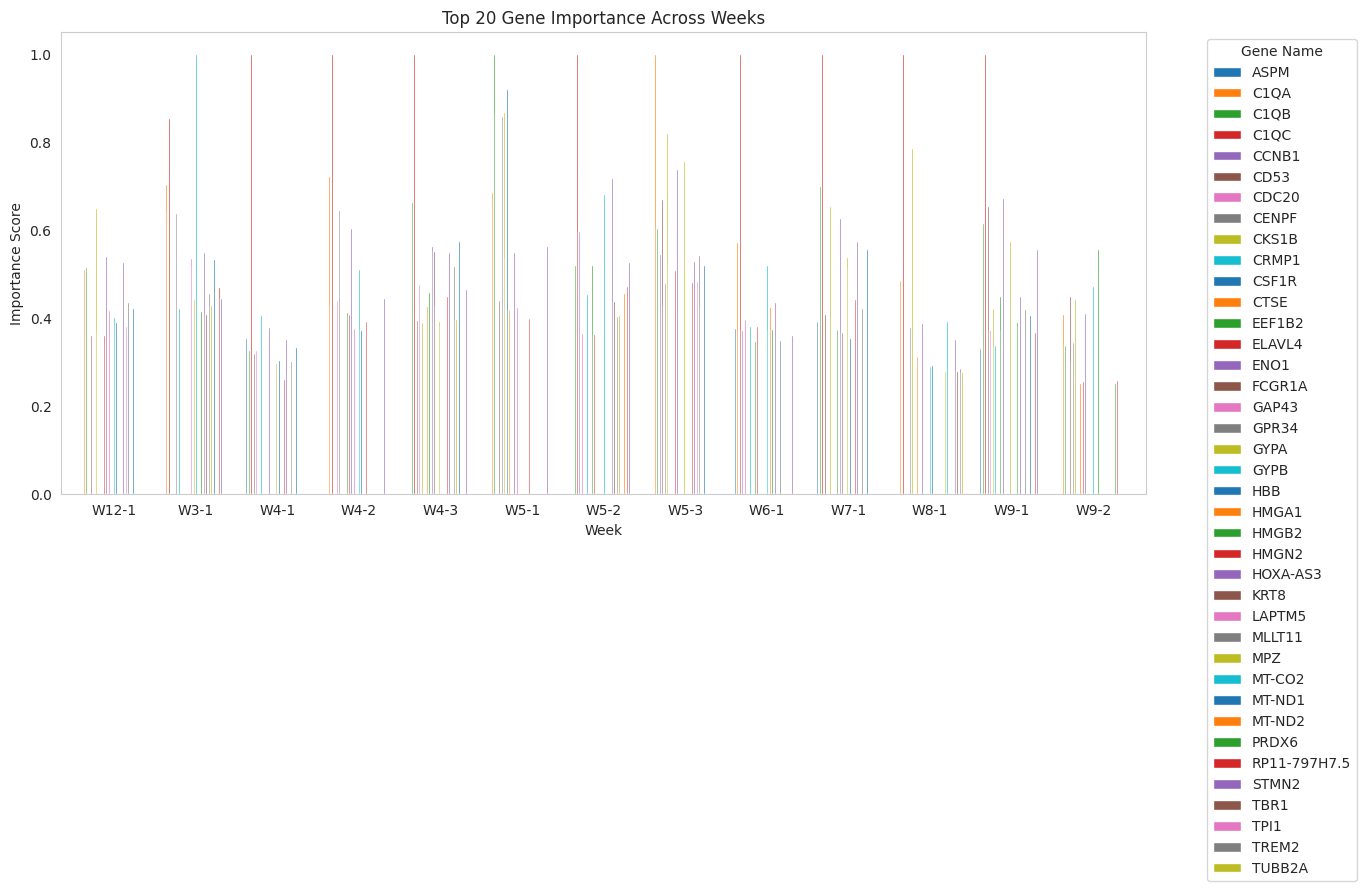

In [129]:
# Plot grouped bar chart
heatmap_pivot.T.plot(kind="bar", figsize=(14, 6), width=0.8)
plt.xlabel("Week")
plt.ylabel("Importance Score")
plt.title("Top 20 Gene Importance Across Weeks")
plt.xticks(rotation=0)
plt.legend(title="Gene Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


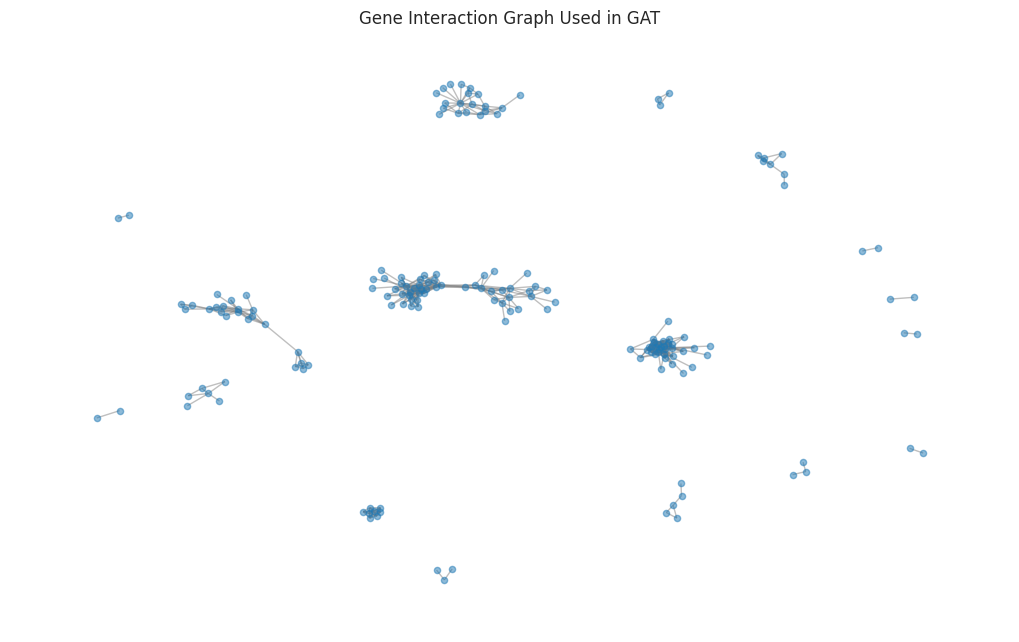

In [130]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric graph to NetworkX for visualization
def visualize_graph(graph_data):
    G = nx.Graph()

    # Add nodes and edges
    edge_index = graph_data.edge_index.cpu().numpy()
    G.add_edges_from(zip(edge_index[0], edge_index[1]))

    plt.figure(figsize=(10, 6))
    nx.draw(G, node_size=20, edge_color="gray", alpha=0.5)
    plt.title("Gene Interaction Graph Used in GAT")
    plt.show()

# Call the function
visualize_graph(gene_graph_data)


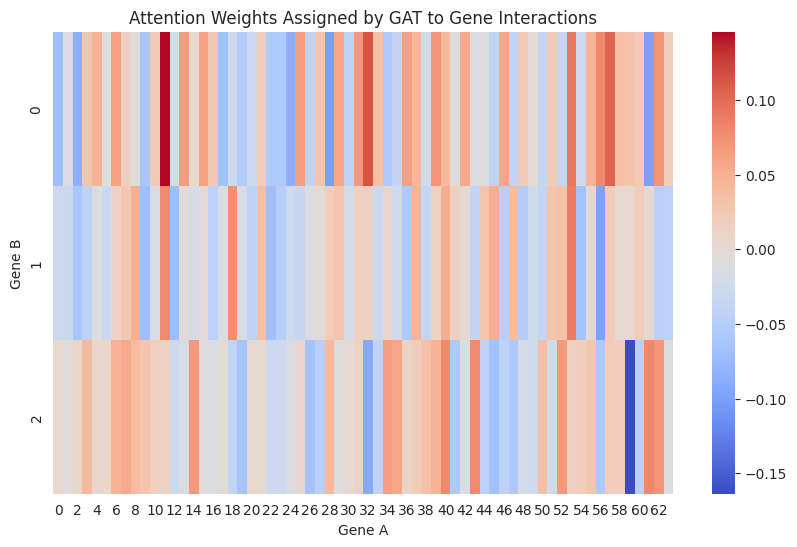

In [131]:
import seaborn as sns
import numpy as np

# Extract attention weights from first GAT layer
gat_layer = gat_model.conv1
attention_weights = gat_layer.att_src.cpu().detach().numpy()

# Reshape or reduce the dimensions of attention_weights
# Option 1: Average over the first dimension
attention_weights = np.mean(attention_weights, axis=0)

# Option 2: Select a specific head (e.g., the first head)
# attention_weights = attention_weights[0]

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights, cmap="coolwarm", annot=False)
plt.title("Attention Weights Assigned by GAT to Gene Interactions")
plt.xlabel("Gene A")
plt.ylabel("Gene B")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


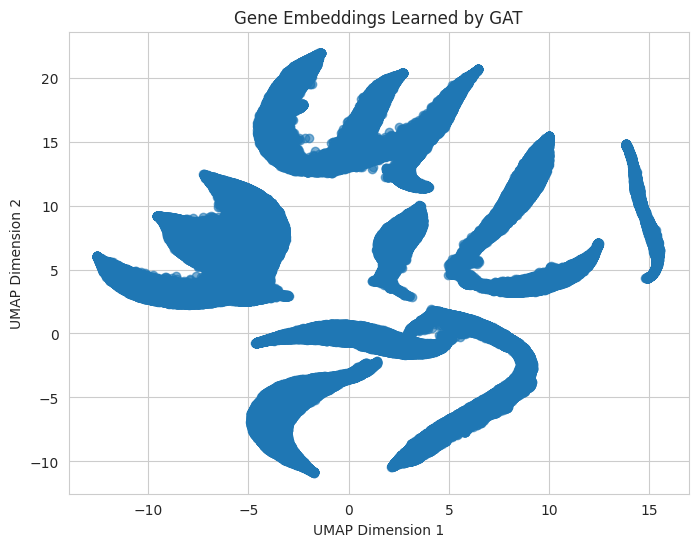

In [132]:
from umap import UMAP
import matplotlib.pyplot as plt
import torch

# Get embeddings from the output of the GAT model
gat_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    gat_output = gat_model(gene_graph_data)  # Pass your data to the model

# Assuming gat_output contains the node embeddings, usually in the shape (num_nodes, embedding_dim)
gat_embeddings = gat_output.cpu().detach().numpy()

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
embeddings_2d = umap.fit_transform(gat_embeddings)

# Scatter plot of gene embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


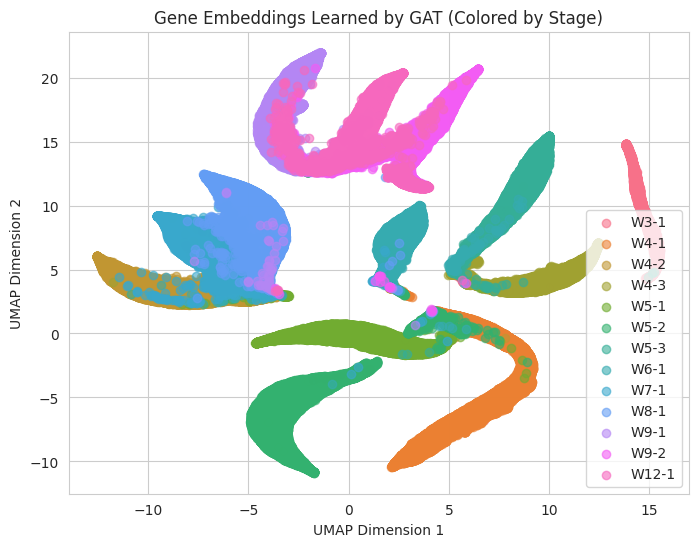

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'week_stage' in adata.obs and embeddings_2d
cluster_labels = adata.obs['week_stage']
unique_clusters = cluster_labels.unique()

# Create stage names (replace with your desired names)
stage_names = {
    "week_stage_value1": "Stage 1",
    "week_stage_value2": "Stage 2",
    "week_stage_value3": "Stage 3",
    # ... add more mappings as needed
}

# Create color palette (same as before)
num_clusters = len(unique_clusters)
palette = sns.color_palette("husl", num_clusters)
cluster_color_map = dict(zip(unique_clusters, palette))

# Color the UMAP plot with stage names
plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    cluster_indices = cluster_labels == cluster
    plt.scatter(
        embeddings_2d[cluster_indices, 0],
        embeddings_2d[cluster_indices, 1],
        color=cluster_color_map[cluster],
        label=stage_names.get(cluster, cluster),  # Use stage name if available, otherwise use original label
        alpha=0.6,
    )

plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("Gene Embeddings Learned by GAT (Colored by Stage)")
plt.legend()
plt.show()

#clusters of cells

Accuracy: 0.9823118679919276
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7333
           1       1.00      0.99      1.00      2469
           2       0.99      1.00      0.99      8635
           3       0.98      0.97      0.98      8226
           4       0.99      0.99      0.99      5900
           5       1.00      1.00      1.00      7758
           6       1.00      0.99      1.00     10850
           7       0.99      1.00      0.99      8408
           8       0.99      0.99      0.99      5324
           9       0.95      0.98      0.96      8397
          10       0.98      0.94      0.96      6057
          11       0.98      0.99      0.98      7673
          12       0.97      0.94      0.96      5631

    accuracy                           0.98     92661
   macro avg       0.98      0.98      0.98     92661
weighted avg       0.98      0.98      0.98     92661



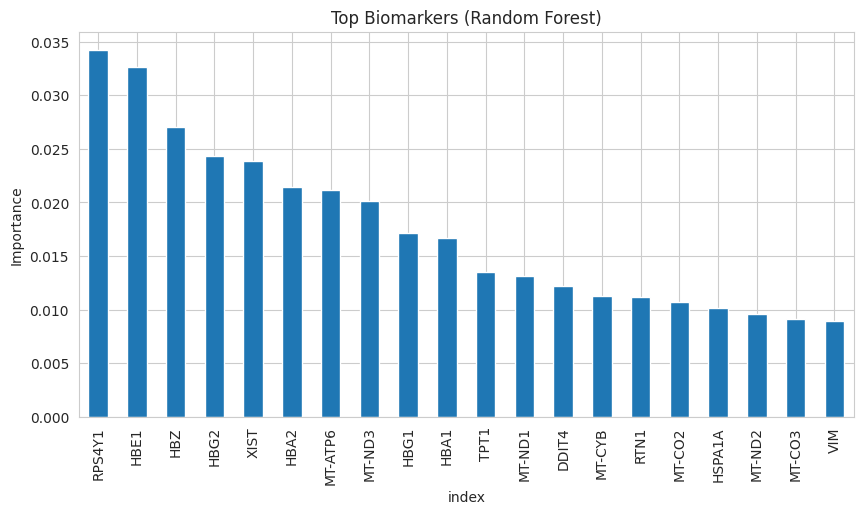

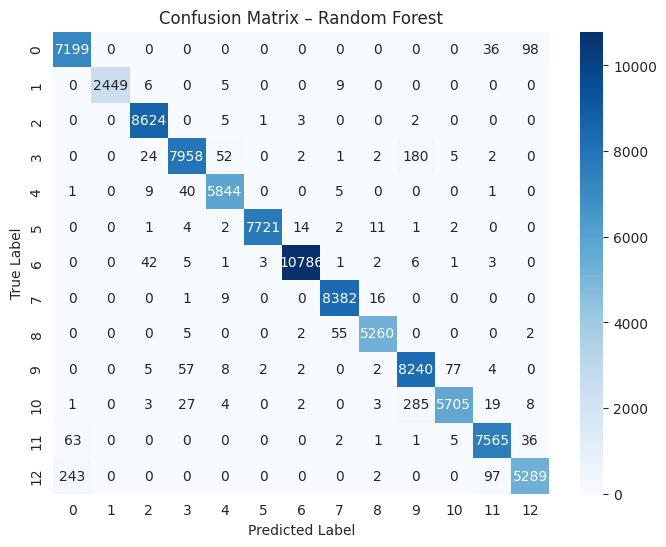

In [134]:
# Prepare data
X = adata.X
y = LabelEncoder().fit_transform(adata.obs["week_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Changed X_val, y_val to X_test, y_test

# --- Random Forest Biomarkers ---
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test) # Changed rf_preds to y_pred_rf and X_val to X_test


# Plot Accuracy
# Change clf to rf_model and X_test to X_val
y_pred = rf_model.predict(X_test) # Changed X_val to X_test
print("Accuracy:", accuracy_score(y_test, y_pred)) # Changed y_val to y_test
print(classification_report(y_test, y_pred)) # Changed y_val to y_test

# Biomarkers
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).nlargest(20)
plt.figure(figsize=(10,5))
rf_importance.plot(kind="bar", title="Top Biomarkers (Random Forest)")
plt.ylabel("Importance")
plt.show()

# In the cell for the confusion matrix:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf) # Now y_test and y_pred_rf are defined
labels = np.unique(y_test)  # adjust if needed

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Random Forest")
plt.show()

In [135]:
!pip install xgboost

In [136]:
import xgboost as xgb

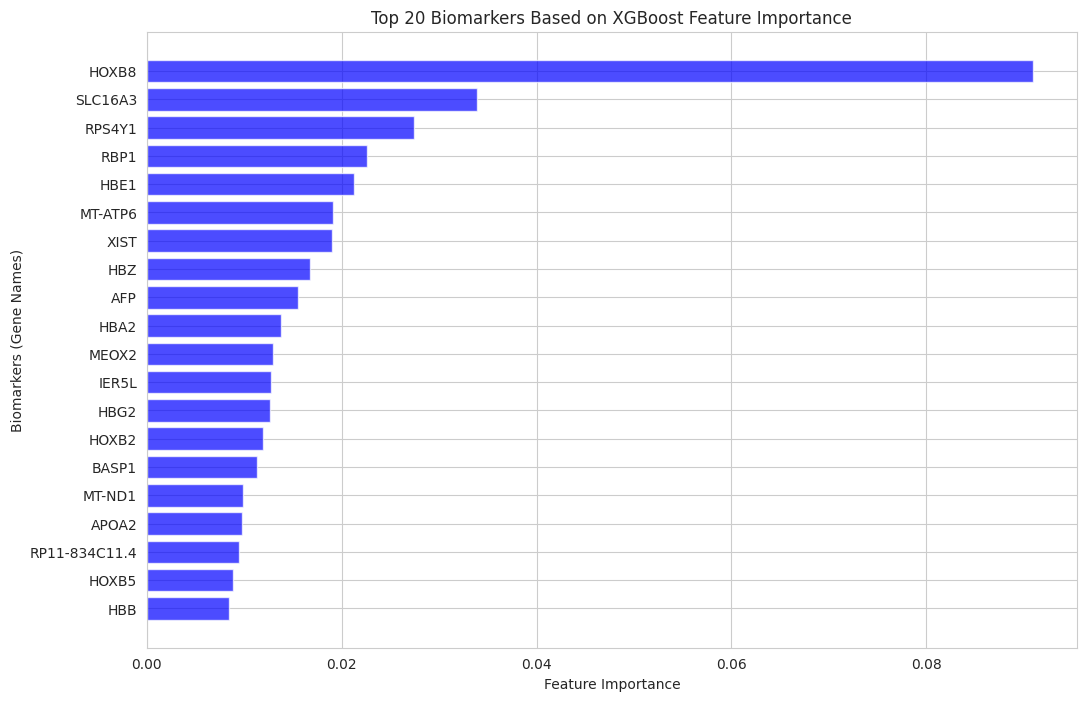

               Gene  XGBoost Importance
1700          HOXB8            0.090925
1730        SLC16A3            0.033915
1933         RPS4Y1            0.027427
417            RBP1            0.022641
1167           HBE1            0.021296
1992        MT-ATP6            0.019089
913            XIST            0.019033
1539            HBZ            0.016762
494             AFP            0.015502
1541           HBA2            0.013757
787           MEOX2            0.012966
1061          IER5L            0.012722
1166           HBG2            0.012590
1692          HOXB2            0.011950
564           BASP1            0.011314
1988         MT-ND1            0.009880
156           APOA2            0.009738
1337  RP11-834C11.4            0.009479
1697          HOXB5            0.008823
1163            HBB            0.008408


In [137]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Extract feature importance from the trained XGBoost model
feature_importance_xgb = xgb_model.feature_importances_

# Assuming 'adata.var_names' contains the gene names, replace 'selected_gene_names'
xgb_importance_df = pd.DataFrame({'Gene': adata.var_names, 'XGBoost Importance': feature_importance_xgb})

# Select top 20 most important biomarkers (genes)
top_20_xgb = xgb_importance_df.sort_values(by='XGBoost Importance', ascending=False).head(20)

# Plot feature importance for XGBoost model
plt.figure(figsize=(12, 8))
plt.barh(top_20_xgb['Gene'], top_20_xgb['XGBoost Importance'], color='blue', alpha=0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Biomarkers (Gene Names)")
plt.title("Top 20 Biomarkers Based on XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Display the top 20 biomarkers
print(top_20_xgb)

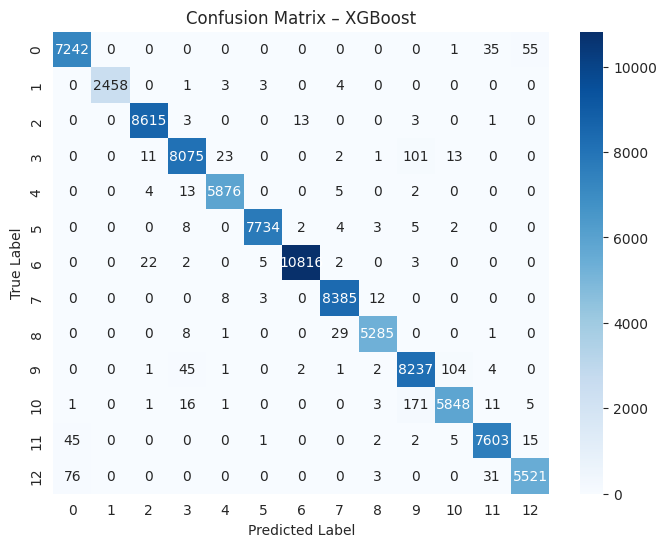

In [138]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
# Predict using XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
labels = np.unique(y_test)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – XGBoost")
plt.show()

In [139]:
!pip install matplotlib-venn --quiet

In [140]:
# Recreate XGBoost feature importance if it’s missing
xgb_importance = pd.Series(xgb_model.feature_importances_, index=adata.var_names)


In [153]:
top_n = 200  # keep consistent for all models

# Recreate RF importance properly
rf_importance = pd.Series(rf_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_rf_genes = set(rf_importance.head(top_n).index)

# XGB already done
xgb_importance = pd.Series(xgb_model.feature_importances_, index=adata.var_names).sort_values(ascending=False)
top_xgb_genes = set(xgb_importance.head(top_n).index)

# GAT attention-based importance
# Calculate mean attention scores per gene (adapt this part based on your GAT model)
edge_index, attention_weights = extract_attention_weights(gat_model, gene_graph_data) # Assuming 'extract_attention_weights' is defined
mean_attention = np.zeros(len(adata.var_names))
for i in range(edge_index.shape[1]):
    source = edge_index[0, i]
    if source < len(adata.var_names):
        # Take the mean of attention weights if it's a multi-head attention
        mean_attention[source] += np.mean(attention_weights[i])
mean_attention /= np.max(mean_attention)  # Normalize

# Create and sort biomarkers based on mean attention
gat_biomarkers = pd.Series(mean_attention, index=adata.var_names).sort_values(ascending=False)
top_gat_genes = set(gat_biomarkers.head(top_n).index)

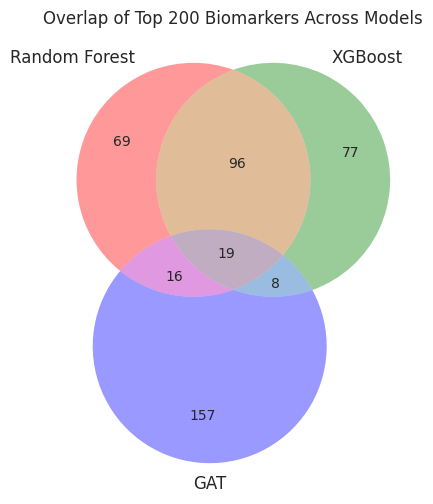

In [154]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
venn3([top_rf_genes, top_xgb_genes, top_gat_genes],
      set_labels=("Random Forest", "XGBoost", "GAT"))
plt.title(f"Overlap of Top {top_n} Biomarkers Across Models")
plt.show()


In [155]:
# Genes shared by all three models
common_all = top_rf_genes & top_xgb_genes & top_gat_genes

# Genes shared by RF and XGB only
common_rf_xgb = (top_rf_genes & top_xgb_genes) - common_all

# Genes shared by GAT and RF only
common_rf_gat = (top_rf_genes & top_gat_genes) - common_all

# Genes shared by GAT and XGB only
common_xgb_gat = (top_xgb_genes & top_gat_genes) - common_all

# Unique to each model
unique_rf = top_rf_genes - (top_xgb_genes | top_gat_genes)
unique_xgb = top_xgb_genes - (top_rf_genes | top_gat_genes)
unique_gat = top_gat_genes - (top_rf_genes | top_xgb_genes)


In [156]:
# Example: genes shared by all models
print("Genes shared by all 3 models (Random Forest, XGBoost, GAT):")
for gene in sorted(common_all):
    print(gene)


Genes shared by all 3 models (Random Forest, XGBoost, GAT):
ENO1
HBB
HBE1
HBG1
HMGB2
HMGN2
HOXB-AS3
ID3
KRT8
MEG3
MLLT11
MT-CO2
MT-ND1
MT-ND2
NEUROD6
NFIA
SLC2A3
STMN2
TPI1


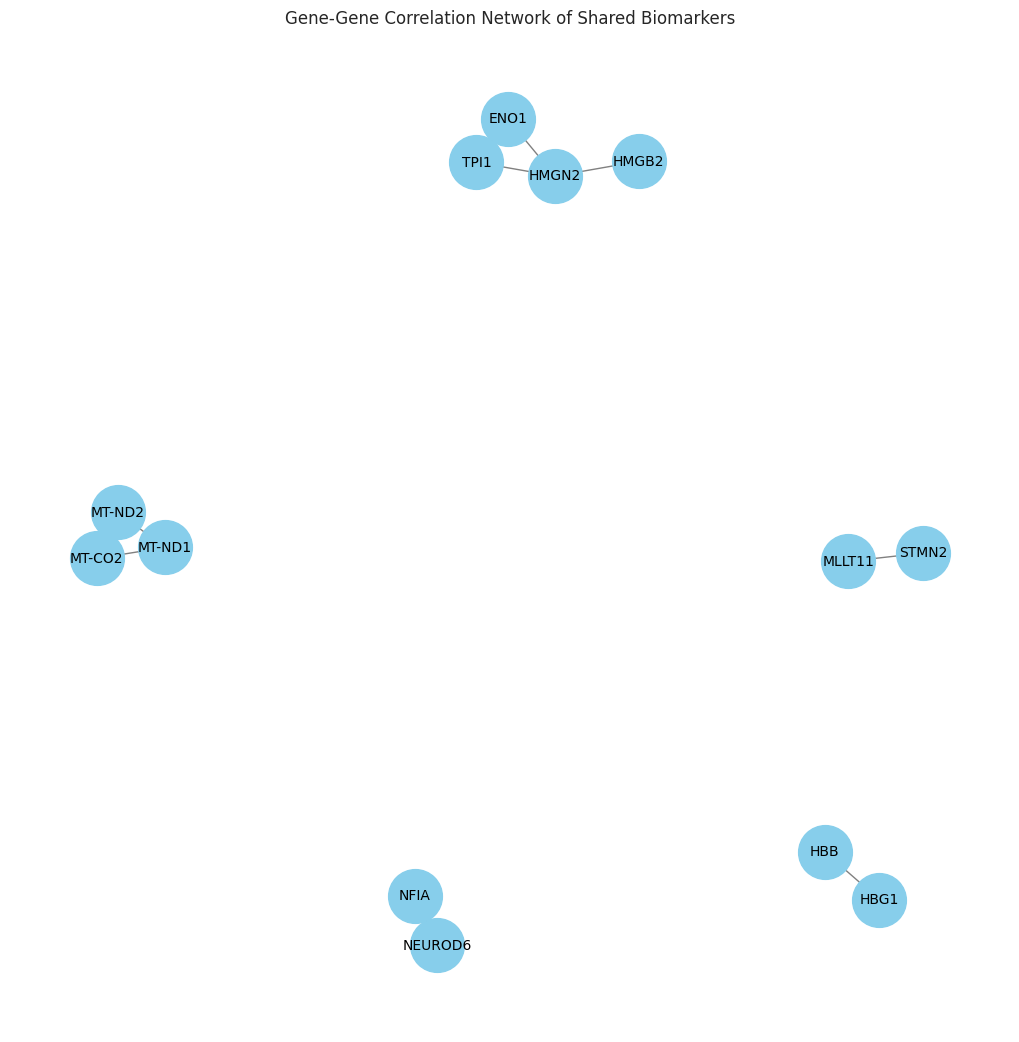

In [158]:
import networkx as nx

# Subset adata to shared genes
adata_shared = adata[:, shared_genes]

# Compute gene-gene correlation
gene_expr = adata_shared.X.T
corr_matrix = np.corrcoef(gene_expr)

# Create graph from strong correlations
G = nx.Graph()
genes = shared_genes
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        corr = corr_matrix[i, j]
        if abs(corr) > 0.6:  # threshold for connection
            G.add_edge(genes[i], genes[j], weight=corr)

# Plot network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=10)
plt.title("Gene-Gene Correlation Network of Shared Biomarkers")
plt.show()


In [159]:
!pip install mygene --quiet

import mygene
mg = mygene.MyGeneInfo()

# Query gene functions
gene_info = mg.querymany(shared_genes, scopes='symbol', fields='symbol,name,summary,disgenet', species='human')

# Convert to DataFrame
import pandas as pd
gene_df = pd.DataFrame(gene_info)[['symbol', 'name', 'summary']]
pd.set_option('display.max_colwidth', 150)

# Show
gene_df


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.9 MB/s eta 0:00:00


INFO:biothings.client:querying 1-19 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,symbol,name,summary
0,HBE1,hemoglobin subunit epsilon 1,The epsilon globin gene (HBE) is normally expressed in the embryonic yolk sac: two epsilon chains together with two zeta chains (an alpha-like glo...
1,NaN,NaN,NaN
2,HOXB-AS3,HOXB cluster antisense RNA 3,NaN
3,MEG3,maternally expressed 3,This gene is a maternally expressed imprinted gene. Multiple alternatively spliced transcript variants have been transcribed from this gene and al...
4,SLC2A3,solute carrier family 2 member 3,Enables dehydroascorbic acid transmembrane transporter activity; glucose binding activity; and glucose transmembrane transporter activity. Involve...
5,TPI1,triosephosphate isomerase 1,"This gene encodes an enzyme, consisting of two identical proteins, which catalyzes the isomerization of glyceraldehydes 3-phosphate (G3P) and dihy..."
6,NaN,NaN,NaN
7,HBG1,hemoglobin subunit gamma 1,"The gamma globin genes (HBG1 and HBG2) are normally expressed in the fetal liver, spleen and bone marrow. Two gamma chains together with two alpha..."
8,ID3,inhibitor of DNA binding 3,"The protein encoded by this gene is a helix-loop-helix (HLH) protein that can form heterodimers with other HLH proteins. However, the encoded prot..."
9,NaN,NaN,NaN


In [160]:
# Export top biomarkers
pd.Series(sorted(top_rf_genes)).to_csv("biomarkers_random_forest.csv", index=False)
pd.Series(sorted(top_xgb_genes)).to_csv("biomarkers_xgboost.csv", index=False)
pd.Series(sorted(top_gat_genes)).to_csv("biomarkers_gat.csv", index=False)

# Export shared genes
pd.Series(sorted(shared_genes)).to_csv("biomarkers_shared_all_models.csv", index=False)

# Expression matrix of shared genes
shared_expr = pd.DataFrame(adata[:, shared_genes].X.toarray(), columns=shared_genes)
shared_expr['stage'] = adata.obs['week_stage'].values
shared_expr.to_csv("shared_gene_expression_matrix.csv", index=False)


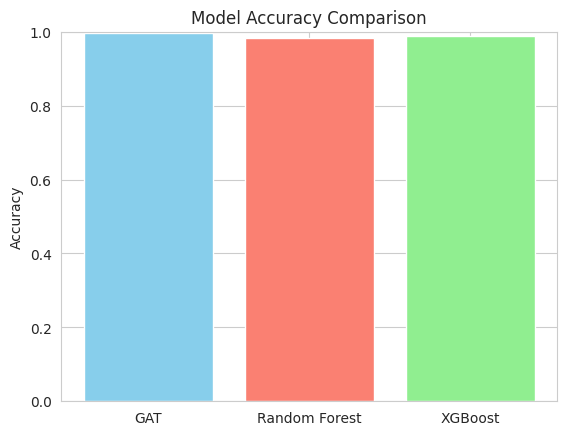

In [162]:
model_names = ['GAT', 'Random Forest', 'XGBoost']

# Calculate or retrieve the accuracy for each model
# Replace with your actual accuracy calculation methods
gat_accuracy = accuracy_score(true_labels, predictions) # Assuming 'true_labels' and 'predictions' are from your GAT model evaluation
# y_test and y_pred are assumed to be from your RF and XGB model, respectively
rf_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

accuracies = [gat_accuracy, rf_accuracy, xgb_accuracy]

plt.bar(model_names, accuracies, color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()
